In [1]:
!set CUDA_VISIBLE_DEVICES=""
!set CUDA_LAUNCH_BLOCKING=1

In [1]:
import pandas as pd
import sklearn
import os
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
# os.environ["KERAS_BACKEND"] = 'torch'
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
import keras

In [2]:
torch.backends.cudnn.enabled = False
torch.cuda.is_available = lambda: False
torch.device("cpu")

device(type='cpu')

In [3]:
torch.cuda.is_available()

False

In [4]:
df = pd.read_csv('pmi-data.csv')
df = df.loc[df['split'] == 'train']

In [5]:
%%html
<h1>1. Datasets and Dataloaders</h1>

In [6]:
train_data, valid_data = sklearn.model_selection.train_test_split(df, test_size=0.25, shuffle=True, random_state=420)

In [7]:
class StrokeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = data['stroke']
        self.samples = data.drop(columns=['stroke', 'id', 'split'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):        
        return torch.Tensor(self.samples.iloc[0].values), torch.tensor(self.labels.iloc[idx])

In [8]:
train_dataloader = DataLoader(StrokeDataset(train_data), batch_size=16, shuffle=True)
valid_dataloader = DataLoader(StrokeDataset(valid_data))

In [9]:
%%html
<h3>I think shuffling is a good idea because if we take a look at the pmi-data.csv we can see that all the cases with stroke=1 come first in the csv so that means if we didnt shuffle, all of them would be chosen for the training and none would be left for the testing</h3>

In [10]:
%%html
<h1>2. Model</h1>

In [239]:
import torch.nn.functional as F
class Model(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.l1 = torch.nn.Linear(in_size, 64)
        self.l2 = torch.nn.Linear(64, 32)
        self.l3 = torch.nn.Linear(32, 32)
        # self.l4 = torch.nn.Linear(32, 32)
        # self.l5 = torch.nn.Linear(32, 32)
        # self.l6 = torch.nn.Linear(32, 32)
        # self.l7 = torch.nn.Linear(32, 32)
        # self.l8 = torch.nn.Linear(16, 16)
        # self.l9 = torch.nn.Linear(16, 16)
        # self.l10 = torch.nn.Linear(16, 8)
        # self.l11 = torch.nn.Linear(32, 16)
        self.l12 = torch.nn.Linear(32, out_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        # x = F.relu(self.l4(x))
        # x = F.relu(self.l5(x))
        # x = F.relu(self.l6(x))
        # x = F.relu(self.l7(x))
        # x = F.relu(self.l8(x))
        # x = F.relu(self.l9(x))
        # x = F.relu(self.l10(x))
        # x = F.relu(self.l11(x))
        x = self.l12(x)
        return x.squeeze()
        

In [63]:
model = Model(10, 1)

In [13]:
# for param in model.parameters():
#     print(param)

In [14]:
%%html
<h1>3. Optimizer and Loss function</h1>

In [44]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [16]:
%%html
<h1>4. Training </h1>

In [64]:
N_EPOCHS = 30

best_acc = 0

hist_train_loss = []
hist_valid_loss = []
hist_accuracy = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            features, labels = data
            y_true.append(labels)
            outputs = model.forward(features)

            loss = loss_fn(outputs, labels[0].float())
            valid_loss += loss.item()
            y_pred.append((torch.sigmoid(outputs) > 0.5).int())

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}')
    if accuracy > best_acc:
        torch.save(model.state_dict(), 'best_unbalanced_accuracy')
        best_acc = accuracy

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9340813464235624, train_loss=1.3189754646215865, valid_loss=1.5513073548695482
Epoch 1, accuracy: 0.9340813464235624, train_loss=1.3218921956731313, valid_loss=1.5513073548695482
Epoch 2, accuracy: 0.9340813464235624, train_loss=1.3189754628423433, valid_loss=1.5513073548695482
Epoch 3, accuracy: 0.9340813464235624, train_loss=1.3218921992316175, valid_loss=1.5513073548695482
Epoch 4, accuracy: 0.9340813464235624, train_loss=1.318975469959316, valid_loss=1.5513073548695482
Epoch 5, accuracy: 0.9340813464235624, train_loss=1.3218921947835096, valid_loss=1.5513073548695482
Epoch 6, accuracy: 0.9340813464235624, train_loss=1.3189754788555317, valid_loss=1.5513073548695482
Epoch 7, accuracy: 0.9340813464235624, train_loss=1.318975457504614, valid_loss=1.5513073548695482
Epoch 8, accuracy: 0.9340813464235624, train_loss=1.3248089445171072, valid_loss=1.5513073548695482
Epoch 9, accuracy: 0.9340813464235624, train_loss=1.318975469959316, valid_loss=1.5513073548695482
Epo

KeyboardInterrupt: 

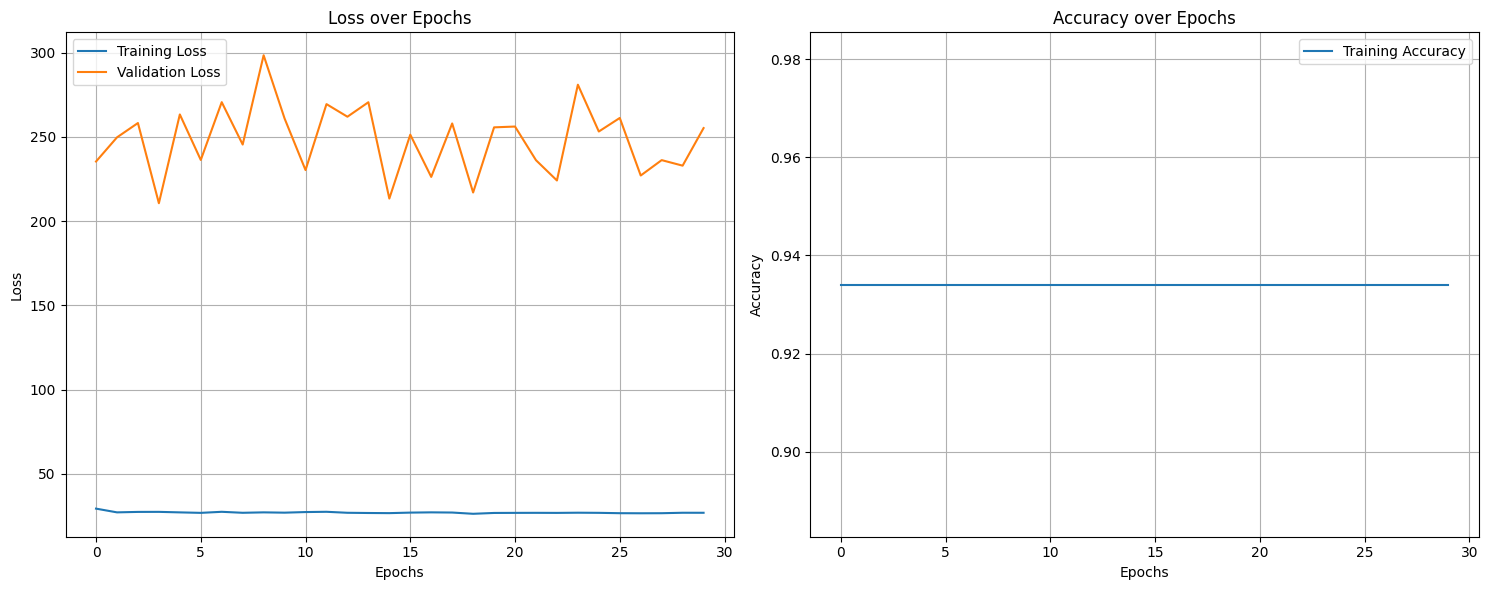

In [18]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
%%html
<h1>5. Evaluation</h1>

In [20]:
model.load_state_dict(torch.load('best_unbalanced_accuracy'))
y_true = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(valid_dataloader, 0):
        features, labels = data
        y_true.append(labels)
        outputs = model.forward(features)

        loss = loss_fn(outputs, labels[0].float())
        valid_loss += loss.item()
        y_pred.append((torch.sigmoid(outputs) > 0.5).int())

Precision: 0.0
Recall: 0.0
F1_score: 0.0


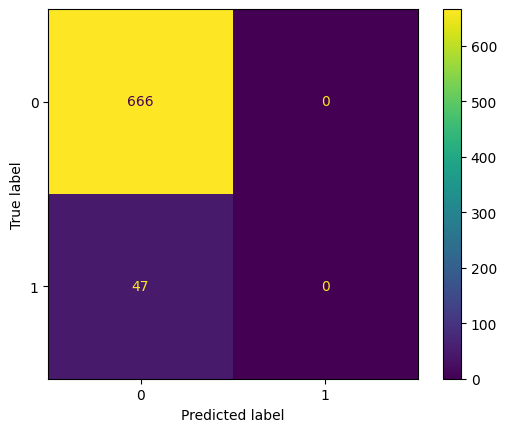

In [21]:
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred,zero_division=0)
f1_score = sklearn.metrics.f1_score(y_true, y_pred,zero_division=0)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [22]:
%%html
<h1>6. Balance the training data distribution</h1>

In [243]:
model = Model(10, 1)
pos_weight = torch.tensor(train_data['stroke'].loc[train_data.stroke == 0].count() / train_data['stroke'].loc[train_data.stroke == 1].count())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [241]:
# Should reach <0.5 loss on 10 samples
x_tiny, y_tiny = next(iter(train_dataloader))[:10]
for _ in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(model(x_tiny), y_tiny.float())
    loss.backward()
    optimizer.step()
print("Overfit test loss:", loss.item())

Overfit test loss: 1.4646937847137451


In [ ]:
N_EPOCHS = 30

best_f1_score = 0

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0

    
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        total_grad = 0
        for p in model.parameters():
            if p.grad is not None:
                total_grad += p.grad.norm().item()
        # if total_grad < 0.1:
        #     print('vanishing gradient')
        # if total_grad > 1000:
        #     print('exploding gradient')
    
        # for name, param in model.named_parameters():
        #     print(param.grad)
        # print(total_grad)
    
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            features, labels = data
            y_true.append(labels)
            outputs = model.forward(features)

            loss = loss_fn(outputs, labels[0].float())
            valid_loss += loss.item()
            y_pred.append((torch.sigmoid(outputs) > 0.5).int())

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9340813464235624, train_loss=1.6508112580918555, valid_loss=1.599249673257536, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 1, accuracy: 0.9340813464235624, train_loss=1.323895014488875, valid_loss=1.5880082564802023, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 2, accuracy: 0.9340813464235624, train_loss=1.3339944557467502, valid_loss=1.5987198326062688, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 3, accuracy: 0.9340813464235624, train_loss=1.3400855749400693, valid_loss=1.5513133190122927, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 4, accuracy: 0.9340813464235624, train_loss=1.3365733516750051, valid_loss=1.567023761977989, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 5, accuracy: 0.9340813464235624, train_loss=1.3227128671176398, valid_loss=1.6438156760926, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 6, accuracy: 0.9340813464235624, train_loss=1.3305303641219637, valid_loss=1.5837840893492625, f1_score=0.0, recall=0.

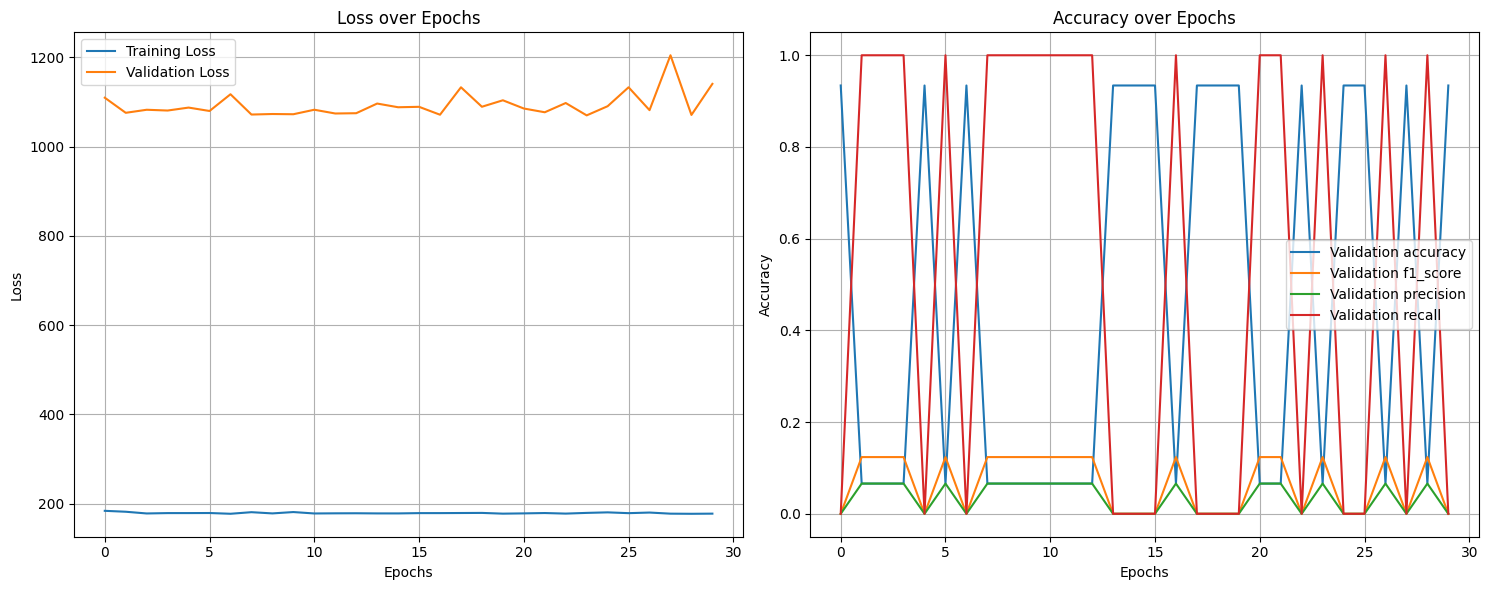

In [219]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Validation accuracy')
plt.plot(hist_f1_score, label='Validation f1_score')
plt.plot(hist_precision, label='Validation precision')
plt.plot(hist_recall, label='Validation recall')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Precision: 0.06591865357643759
Recall: 1.0
F1_score: 0.12368421052631579


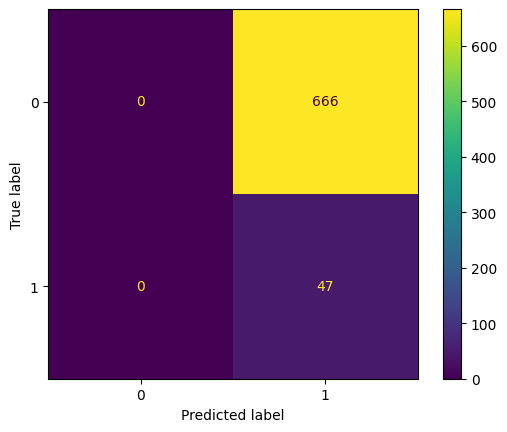

In [201]:
model.load_state_dict(torch.load('best_balanced_f1'))
y_true = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(valid_dataloader, 0):
        features, labels = data
        y_true.append(labels)
        outputs = model.forward(features)

        loss = loss_fn(outputs, labels[0].float())
        valid_loss += loss.item()
        y_pred.append((torch.sigmoid(outputs) > 0.5).int())
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [28]:
%%html
<h1>7. Focal Loss</h1>

In [29]:
class BinaryFocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.exp(-BCE_loss)  # pt = p if target=1, else 1-p
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        F_loss = alpha_t * (1 - pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [30]:
model = Model(10, 1)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = BinaryFocalLoss(alpha=0.7, gamma=2)

In [31]:
N_EPOCHS = 30

best_f1_score = 0

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            features, labels = data
            y_true.append(labels)
            outputs = model.forward(features)
    
            loss = loss_fn(outputs, labels[0].float())
            valid_loss += loss.item()
            y_pred.append((torch.sigmoid(outputs) > 0.5).int())

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1_focal_loss')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9340813464235624, train_loss=0.0421881112772044, valid_loss=0.042546597219282584, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 1, accuracy: 0.06591865357643759, train_loss=0.03592792135005671, valid_loss=0.06774850204315293, f1_score=0.12368421052631579, recall=1.0, precision=0.06591865357643759, *
Epoch 2, accuracy: 0.9340813464235624, train_loss=0.03430647204346423, valid_loss=0.04732172201592658, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 3, accuracy: 0.9340813464235624, train_loss=0.03184632701736722, valid_loss=0.047389173438722926, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 4, accuracy: 0.9340813464235624, train_loss=0.03167955155281086, valid_loss=0.03960451733472471, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 5, accuracy: 0.9340813464235624, train_loss=0.030608826951964745, valid_loss=0.04689942087147379, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 6, accuracy: 0.9340813464235624, train_loss=0.029825560383693273, va

Precision: 0.06591865357643759
Recall: 1.0
F1_score: 0.12368421052631579


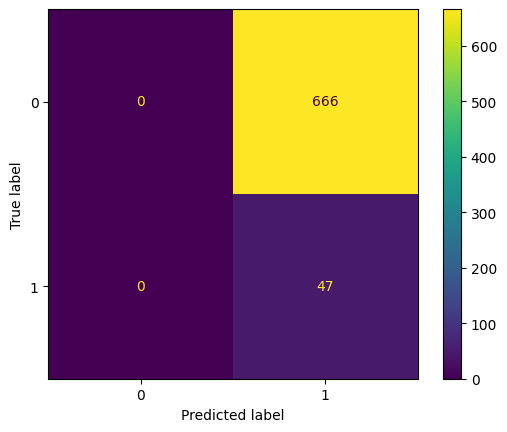

In [32]:
model =  Model(10, 1)
model.load_state_dict(torch.load('best_balanced_f1_focal_loss'))
y_true = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(valid_dataloader, 0):
        features, labels = data
        y_true.append(labels)
        outputs = model.forward(features)

        loss = loss_fn(outputs, labels[0].float())
        valid_loss += loss.item()
        y_pred.append((torch.sigmoid(outputs) > 0.5).int())
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [33]:
%%html
<h1>8. Inspecting model outputs. NOT DONE YET</h1>

In [37]:
model_unbalanced_accuracy = Model(10, 1)
model_unbalanced_accuracy.load_state_dict(torch.load('best_unbalanced_accuracy'))

model_balanced_f1 = Model(10, 1)
model_balanced_f1.load_state_dict(torch.load('best_balanced_f1'))

model_balanced_f1_focal = Model(10, 1)
model_balanced_f1_focal.load_state_dict(torch.load('best_balanced_f1_focal_loss'))

<All keys matched successfully>

In [38]:
def probabilities(model):
    probs = []
    with torch.no_grad():
        for data, label in valid_dataloader:
            if label == 0:
                continue
            logits = model(data)
            probs.append(torch.sigmoid(logits))        
    return np.array(probs)

vals_model_unbalanced_accuracy = probabilities(model_unbalanced_accuracy)[0]
vals_model_balanced_f1 = probabilities(model_balanced_f1)[0]
vals_model_f1_focal = probabilities(model_balanced_f1_focal)[0]

TypeError: object of type 'numpy.float32' has no len()

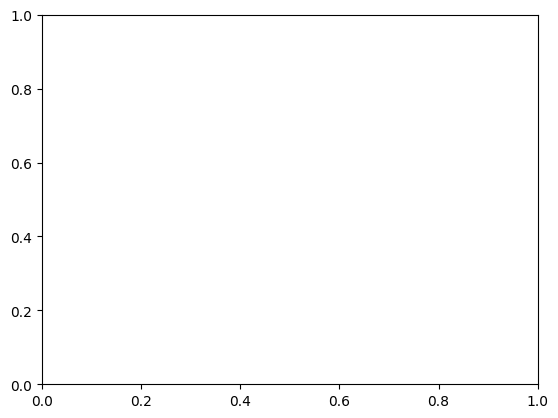

In [39]:
fig, ax = plt.subplots()

N = len(vals_model_unbalanced_accuracy)
x = np.arange(N)  # x-axis positions
width = 0.25  # Width of each bar

# Plot each set of bars with adjusted positions
ax.bar(x - width, vals_model_unbalanced_accuracy, width,
       edgecolor='white', linewidth=0.7, label='Unbalanced Accuracy')
ax.bar(x, vals_model_balanced_f1, width,
       edgecolor='white', linewidth=0.7, label='Balanced F1')
ax.bar(x + width, vals_model_f1_focal, width,
       edgecolor='white', linewidth=0.7, label='F1 Focal')

# Configure axes and labels
ax.set(
    xticks=x,  # All values in the list (indices)
    ylim=(0, 1),
    yticks=np.linspace(0, 1, 11)  # Ticks every 0.1
)
ax.legend()

plt.show()

In [40]:
%%html
<h1>9. Beyond default thresholds</h1>

In [41]:
def get_f1_score_models(threshold):
    f1_scores_model_unbalanced_accuracy = None
    f1_scores_model_balanced_f1 = None
    f1_scores_model_balanced_f1_focal = None

    y_pred_model_unbalanced_accuracy = []
    y_pred_model_balanced_f1 = []
    y_pred_model_balanced_f1_focal = []
    y_true = []
    
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            features, labels = data
            y_true.append(labels)
            
            # outputs = model.forward(features)
            # y_pred.append(torch.sigmoid(outputs) > threshold)
        
            y_pred_model_unbalanced_accuracy.append(torch.sigmoid(model_unbalanced_accuracy(features)) > threshold)
            y_pred_model_balanced_f1.append(toch.sigmoid(model_balanced_f1(features)) > threshold)
            y_pred_model_balanced_f1_focal.append(torch.sigmoid(model_balanced_f1_focal(features)) > threshold)

    f1_scores_model_unbalanced_accuracy = sklearn.metrics.f1_score(y_true, y_pred_model_unbalanced_accuracy)
    f1_scores_model_balanced_f1 = sklearn.metrics.f1_score(y_true, y_pred_model_balanced_f1)
    f1_scores_model_balanced_f1_focal = sklearn.metrics.f1_score(y_true, y_pred_model_balanced_f1_focal)

    return f1_scores_model_unbalanced_accuracy, f1_scores_model_balanced_f1, f1_scores_model_balanced_f1_focal